# ** Melanoma - Skin Cancer Detection - EfficientNets Tensorflow 2**

Melanoma is the most serious type of skin cancer, develops in the cells (melanocytes) that produce melanin, early detection is key for recovery.

- Set up TPU
- Data augmentations in generator - random rotation, random shear, random zoom, random shift
- Callbacks for learning rate scheduler & model checkpoint saving
- Binary cross entropy loss & AUC metric tracking
- Train in full EfficientNets B0 to B7 family use as ensembles
- Graphing tools for loss and auc metric by epoch for all models
- Build a decision tree classifier to ensemble EffNet family and take straight average of all EffNet Family
- Use these two ensembling techniques for inference with test time augmentations

Core code inspiration - https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once

### **Params/Configs Specification**

In [1]:
## device setting
DEVICE = "TPU"

## list of B0 to B7 architectures you want to train - provide as list of integers between 0,1,2,3,4,5,6,7
build_effnet_arch = [0, 1, 2, 3, 4, 5, 6, 7]

## configurations
CFG = dict(
    
    ## data sizing
    batch_size        =  16,
    read_size         = 256, 
    crop_size         = 250, 
    ## input size of the image to the network
    net_size          = 248,
    
    ## learning rate schedule
    LR_START          =   0.000003,
    LR_MAX            =   0.000020,
    LR_MIN            =   0.000001,
    LR_RAMPUP_EPOCHS  =   5,
    LR_SUSTAIN_EPOCHS =   0,
    LR_EXP_DECAY      =   0.8,
    epochs            =  15,
    
    ## augmentations - rotation, shear, zoom - horizontal & width, shifting - horizontal & width
    rot               = 180.0,
    shr               =   1.5,
    hzoom             =   6.0,
    wzoom             =   6.0,
    hshift            =   6.0,
    wshift            =   6.0,

    
    ## optimizier 
    optimizer         = 'adam',
    label_smooth_fac  =   0.05,
    
    ## test time augmentation
    tta_steps         =  25    
)

### **Install EfficientNet**

In [2]:
!pip install -q efficientnet

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


### **Import Required Libraries**

In [3]:
## regular py imports
import os, random, re, math, time
## set seed
random.seed(a=42)
import numpy as np
import pandas as pd

## tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K
import efficientnet.tfkeras as efn

## import for images - display 
import PIL
import matplotlib.pyplot as plt
%matplotlib inline

## import for pulling in the datasets right inside kaggle
from kaggle_datasets import KaggleDatasets

## import for progress bar
from tqdm import tqdm

### **Read the data**

In [4]:
## list files in kaggle dataset
BASEPATH = "../input/siim-isic-melanoma-classification"
os.listdir(BASEPATH)

['train.csv',
 'train',
 'tfrecords',
 'jpeg',
 'test.csv',
 'test',
 'sample_submission.csv']

In [5]:
## read in the train/test data
df_train = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))
df_train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
print(df_train.shape)
print(df_test.shape)

(33126, 8)
(10982, 5)


In [7]:
## get google cloud storage path for melanoma images
GCS_PATH    = KaggleDatasets().get_gcs_path('melanoma-256x256')
print(GCS_PATH)

gs://kds-5551824cd70b3b487cf69c7e8e87023b9fb5da2c7b0a830326bdd53f


In [8]:
## read in a list of files named like train*.tfrec
## convert list to array
files_train = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/train*.tfrec')))
files_test  = np.sort(np.array(tf.io.gfile.glob(GCS_PATH + '/test*.tfrec')))

### **TPU Configuration**

In [9]:
## remember to turn on the accelerator switch to TPU v3-8

if DEVICE == "TPU":
    print("connecting to TPU...")
    try:
        ## for distributed execution for tf to communicated w clister cluster management systems
        ## info of the tpu devices
        tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
        print('Running on TPU ', tpu.master())
    except ValueError:
        print("Could not connect to TPU")
        tpu = None

    if tpu:
        try:
            print("initializing  TPU ...")
            ## config for tpu
            
            ## connect to clister
            tf.config.experimental_connect_to_cluster(tpu)
            ## initialize tpu devices -- pass cluster resolver from above
            tf.tpu.experimental.initialize_tpu_system(tpu)
            ## Synchronous training on TPUs -- takes tpu cluster resolver
            strategy = tf.distribute.experimental.TPUStrategy(tpu)
            print("TPU initialized")
        except _:
            print("failed to initialize TPU")
    else:
        DEVICE = "GPU"

if DEVICE != "TPU":
    print("Using default strategy for CPU and single GPU")
    ## execution strategy
    strategy = tf.distribute.get_strategy()

if DEVICE == "GPU":
    ## list of gpus availble to the host at runtime
    print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
    

    
## auto sharding for data pipelines?
AUTO     = tf.data.experimental.AUTOTUNE

## print number of devices accessible
REPLICAS = strategy.num_replicas_in_sync
print(f'REPLICAS: {REPLICAS}')

connecting to TPU...
Running on TPU  grpc://10.0.0.2:8470
initializing  TPU ...
TPU initialized
REPLICAS: 8


In [10]:
## augmentations and trandformations -- replace with ImageDataGenerator
## ImageDataGenerator breaks on TPUs, keep checking the open request below
## https://github.com/tensorflow/tensorflow/issues/34346 

def get_mat(rotation, shear, height_zoom, width_zoom, height_shift, width_shift):
    # returns 3x3 transformmatrix which transforms indicies
        
    # CONVERT DEGREES TO RADIANS
    rotation = math.pi * rotation / 180.
    shear    = math.pi * shear    / 180.

    def get_3x3_mat(lst):
        return tf.reshape(tf.concat([lst],axis=0), [3,3])
    
    # ROTATION MATRIX
    c1   = tf.math.cos(rotation)
    s1   = tf.math.sin(rotation)
    one  = tf.constant([1],dtype='float32')
    zero = tf.constant([0],dtype='float32')
    
    rotation_matrix = get_3x3_mat([c1,   s1,   zero, 
                                   -s1,  c1,   zero, 
                                   zero, zero, one])    
    # SHEAR MATRIX
    c2 = tf.math.cos(shear)
    s2 = tf.math.sin(shear)    
    
    shear_matrix = get_3x3_mat([one,  s2,   zero, 
                                zero, c2,   zero, 
                                zero, zero, one])        
    # ZOOM MATRIX
    zoom_matrix = get_3x3_mat([one/height_zoom, zero,           zero, 
                               zero,            one/width_zoom, zero, 
                               zero,            zero,           one])    
    # SHIFT MATRIX
    shift_matrix = get_3x3_mat([one,  zero, height_shift, 
                                zero, one,  width_shift, 
                                zero, zero, one])
    
    ## returns filter of rotation, sheared, zoomed, shifted (each transform tyrned on or off) to be convolved?
    return K.dot(K.dot(rotation_matrix, shear_matrix), 
                 K.dot(zoom_matrix,     shift_matrix))



def transform(image, cfg):    
    # input image - is one image of size [dim,dim,3] not a batch of [b,dim,dim,3]
    # output - image randomly rotated, sheared, zoomed, and shifted
    
    DIM = cfg["read_size"]
    
    ## dim to trim
    XDIM = DIM%2 #fix for size 331
    
    ## random number from a normal dist for randomizing transforms
    rot = cfg['rot'] * tf.random.normal([1], dtype='float32')
    shr = cfg['shr'] * tf.random.normal([1], dtype='float32') 
    h_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['hzoom']
    w_zoom = 1.0 + tf.random.normal([1], dtype='float32') / cfg['wzoom']
    h_shift = cfg['hshift'] * tf.random.normal([1], dtype='float32') 
    w_shift = cfg['wshift'] * tf.random.normal([1], dtype='float32') 

    # GET TRANSFORMATION MATRIX
    m = get_mat(rot,shr,h_zoom,w_zoom,h_shift,w_shift) 

    # LIST DESTINATION PIXEL INDICES
    x   = tf.repeat(tf.range(DIM//2, -DIM//2,-1), DIM)
    y   = tf.tile(tf.range(-DIM//2, DIM//2), [DIM])
    z   = tf.ones([DIM*DIM], dtype='int32')
    idx = tf.stack( [x,y,z] )
    
    # ROTATE DESTINATION PIXELS ONTO ORIGIN PIXELS
    idx2 = K.dot(m, tf.cast(idx, dtype='float32'))
    idx2 = K.cast(idx2, dtype='int32')
    idx2 = K.clip(idx2, -DIM//2+XDIM+1, DIM//2)
    
    # FIND ORIGIN PIXEL VALUES           
    idx3 = tf.stack([DIM//2-idx2[0,], DIM//2-1+idx2[1,]])
    d    = tf.gather_nd(image, tf.transpose(idx3))
        
    return tf.reshape(d,[DIM, DIM,3])

In [11]:
## define the serialized data formats - tfrecords
def read_labeled_tfrecord(example):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
        'patient_id'                   : tf.io.FixedLenFeature([], tf.int64),
        'sex'                          : tf.io.FixedLenFeature([], tf.int64),
        'age_approx'                   : tf.io.FixedLenFeature([], tf.int64),
        'anatom_site_general_challenge': tf.io.FixedLenFeature([], tf.int64),
        'diagnosis'                    : tf.io.FixedLenFeature([], tf.int64),
        'target'                       : tf.io.FixedLenFeature([], tf.int64)
    } 
    ## parse each example passed
    example = tf.io.parse_single_example(example, tfrec_format)
    ## return image and target only not contextual info
    return example['image'], example['target']


## test image read in
def read_unlabeled_tfrecord(example, return_image_name):
    tfrec_format = {
        'image'                        : tf.io.FixedLenFeature([], tf.string),
        'image_name'                   : tf.io.FixedLenFeature([], tf.string),
    }
    ## parse
    example = tf.io.parse_single_example(example, tfrec_format)
    ## read out
    return example['image'], example['image_name'] if return_image_name else 0


def prepare_image(img, cfg=None, augment=True):
    ##
    img = tf.image.decode_jpeg(img, channels=3)
    ## resize 
    img = tf.image.resize(img, [cfg['read_size'], cfg['read_size']])
    ## normalize
    img = tf.cast(img, tf.float32) / 255.0
    
    ## transorm the image if augment is set
    if augment:
        img = transform(img, cfg)
        img = tf.image.random_crop(img, [cfg['crop_size'], cfg['crop_size'], 3])
        img = tf.image.random_flip_left_right(img)
        img = tf.image.random_hue(img, 0.01)
        img = tf.image.random_saturation(img, 0.7, 1.3)
        img = tf.image.random_contrast(img, 0.8, 1.2)
        img = tf.image.random_brightness(img, 0.1)

    else:
        img = tf.image.central_crop(img, cfg['crop_size'] / cfg['read_size'])
                                   
    img = tf.image.resize(img, [cfg['net_size'], cfg['net_size']])
    img = tf.reshape(img, [cfg['net_size'], cfg['net_size'], 3])
    ## return the image 
    return img

## not sure
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) 
         for filename in filenames]
    return np.sum(n)

In [12]:
## create data pipes
def get_dataset(files, cfg, augment = False, shuffle = False, repeat = False, 
                labeled=True, return_image_names=True):
    
    ## data pipeline
    ds = tf.data.TFRecordDataset(files, num_parallel_reads=AUTO)
    ## Caches the elements in this dataset.
    ds = ds.cache()
    
    ## repeat this data
    if repeat:
        ds = ds.repeat()
    
    ## shuffle randomly the elements of the dataset
    ## is 1024*8 the buffer size?
    if shuffle: 
        ds = ds.shuffle(1024*8)
        opt = tf.data.Options()
        ## outputs need to be produced in deterministic order?
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
        
    if labeled: 
        ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
    else:
        ds = ds.map(lambda example: read_unlabeled_tfrecord(example, return_image_names), 
                    num_parallel_calls=AUTO)      
    
    ds = ds.map(lambda img, imgname_or_label: (prepare_image(img, augment=augment, cfg=cfg), 
                                               imgname_or_label), 
                num_parallel_calls=AUTO)
    
    ## batches
    ds = ds.batch(cfg['batch_size'] * REPLICAS)
    ## prefetch elements from this dataset
    ds = ds.prefetch(AUTO)
    return ds

### **Test Input Pipeline**

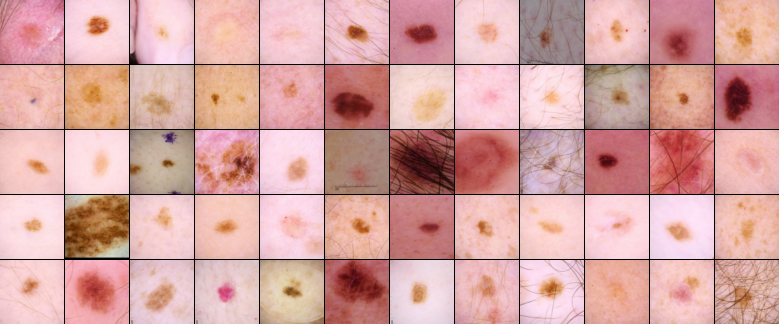

In [13]:
def show_dataset(thumb_size, cols, rows, ds):
    ## just a tool to show images in train
    mosaic = PIL.Image.new(mode='RGB', size=(thumb_size*cols + (cols-1), 
                                             thumb_size*rows + (rows-1)))
   
    for idx, data in enumerate(iter(ds)):
        img, target_or_imgid = data
        ix  = idx % cols
        iy  = idx // cols
        img = np.clip(img.numpy() * 255, 0, 255).astype(np.uint8)
        img = PIL.Image.fromarray(img)
        img = img.resize((thumb_size, thumb_size), resample=PIL.Image.BILINEAR)
        mosaic.paste(img, (ix*thumb_size + ix, 
                           iy*thumb_size + iy))

    display(mosaic)
    
ds = get_dataset(files_train, CFG).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

### **Image Augmentation**

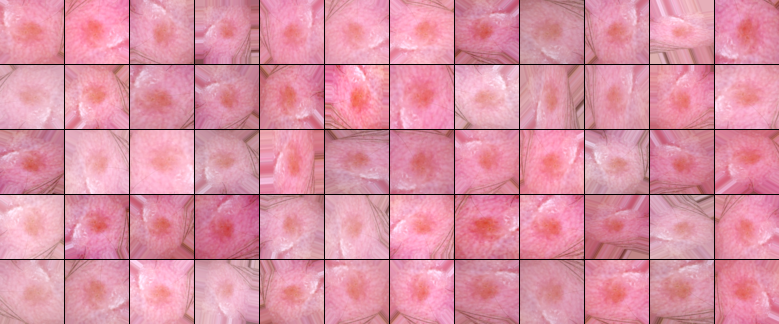

In [14]:
## show image augmentation on a particular image
ds = tf.data.TFRecordDataset(files_train, num_parallel_reads=AUTO)
ds = ds.take(1).cache().repeat()
ds = ds.map(read_labeled_tfrecord, num_parallel_calls=AUTO)
ds = ds.map(lambda img, target: (prepare_image(img, cfg=CFG, augment=True), target), 
            num_parallel_calls=AUTO)
ds = ds.take(12*5)
ds = ds.prefetch(AUTO)

show_dataset(64, 12, 5, ds)

### **Test Data Images**

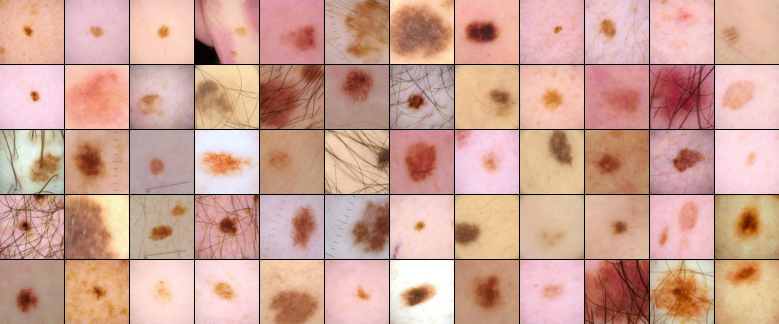

In [15]:
## pull out test set images
ds = get_dataset(files_test, CFG, labeled=False).unbatch().take(12*5)   
show_dataset(64, 12, 5, ds)

## CALLBACKS...

- Learning Rate scheduler 
- Checkpoint model save after every epoch - added during model fitting

In [16]:
## set a callback for lr scheduling
def get_lr_callback(cfg):
    lr_start   = cfg['LR_START']
    lr_max     = cfg['LR_MAX'] * strategy.num_replicas_in_sync
    lr_min     = cfg['LR_MIN']
    lr_ramp_ep = cfg['LR_RAMPUP_EPOCHS']
    lr_sus_ep  = cfg['LR_SUSTAIN_EPOCHS']
    lr_decay   = cfg['LR_EXP_DECAY']
   
    def lrfn(epoch):
        if epoch < lr_ramp_ep:
            lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
            
        elif epoch < lr_ramp_ep + lr_sus_ep:
            lr = lr_max
            
        else:
            lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
            
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=False)
    return lr_callback

### **Build Model - helper**

In [17]:
def get_model(cfg, model, Netname):
    
    model_input = tf.keras.Input(shape=(cfg['net_size'], cfg['net_size'], 3), name='imgIn')
    dummy = tf.keras.layers.Lambda(lambda x:x)(model_input)    
    outputs = []    

    ## get the attributes of efn - effNet
    constructor = getattr(efn, model)
    ## remove top, use imagenet weights
    x = constructor(include_top=False, weights='imagenet', 
                    input_shape=(cfg['net_size'], cfg['net_size'], 3), 
                    pooling='avg')(dummy)

    ## add a dense layer
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    outputs.append(x)
    
    ## create model
    model = tf.keras.Model(model_input, outputs, name=Netname)
    model.summary()
    
    return model


### **Compile Model - helper**

In [18]:
def compile_new_model(cfg, model, Netname):    
    with strategy.scope():
        model = get_model(cfg, model, Netname)
        ## loss -- maybe add cost to miss classifying class 1
        losses = tf.keras.losses.BinaryCrossentropy(label_smoothing = cfg['label_smooth_fac'])
        ## compile
        ## add f1/f2 score
        model.compile(
            optimizer = cfg['optimizer'],
            loss      = losses,
            metrics   = [tf.keras.metrics.AUC(name='auc')])
        
    return model

# **Fit Model**

In [19]:
## directory for model checkpoints
! mkdir 'model_checkpoints' 

In [20]:
ds_train     = get_dataset(files_train, CFG, augment=True, shuffle=True, repeat=True)
ds_train     = ds_train.map(lambda img, label: (img, tuple([label])))

steps_train  = count_data_items(files_train) / (CFG['batch_size'] * REPLICAS)


select_EffNet_Family = []
select_EffNet_Family_history = []
print("\n Selected Following EffNets for Training")
print([(str('EfficientNetB') + str(i)) for i in build_effnet_arch])


## when saving after each epoch - select a few epochs to keep
keep_epoch = [15] 
all_epochs = [i for i in range(1,16)]
rm_list = [str(i).zfill(2) for i in all_epochs if i not in keep_epoch]



for arch in build_effnet_arch:
    eff_arch = str('EfficientNetB') + str(arch)
    print('\n******************',eff_arch,'*******************\n')
    model = compile_new_model(CFG, eff_arch, eff_arch)
    ## add a checkpoint callback - save model after every epoch for picking final model
    ## much more useful when using validation set - monitor validation loss and keep best
    checkpoint_filename= str(eff_arch)+str('-weights.{epoch:02d}.hdf5')
    model_checkpoint_callback  =  tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join('model_checkpoints', checkpoint_filename)
                                                                     , save_weights_only=True
                                                                     )
    
    print(("\n Begin Training "+eff_arch))
    history = model.fit(ds_train
                        , verbose = 1
                        , steps_per_epoch  = steps_train
                        , epochs           = CFG['epochs']
                        , callbacks        = [get_lr_callback(CFG)
                                              ,model_checkpoint_callback])
    print("Done Training ", eff_arch, end = "\n")
    

    ## checkpoint clean up - Only keep epoch 15, ideally would save multiple like 8,14, 18
    for i in rm_list:
        rm_file = str(eff_arch)+str('-weights.')+str(i)+str('.hdf5')
        os.remove(os.path.join('model_checkpoints', rm_file))
    print('Checkpoint CleanUp')
    ##

    ## put model in the family list
    select_EffNet_Family.append(model)
    select_EffNet_Family_history.append(history)



 Selected Following EffNets for Training
['EfficientNetB0', 'EfficientNetB1', 'EfficientNetB2', 'EfficientNetB3', 'EfficientNetB4', 'EfficientNetB5', 'EfficientNetB6', 'EfficientNetB7']

****************** EfficientNetB0 *******************

16809984/16804768 [==============================] - 1s 0us/step
Model: "EfficientNetB0"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
imgIn (InputLayer)           [(None, 248, 248, 3)]     0         
_________________________________________________________________
lambda (Lambda)              (None, 248, 248, 3)       0         
_________________________________________________________________
efficientnet-b0 (Model)      (None, 1280)              4049564   
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 4,050,845
Trainable params: 4,008,829
Non-trainable params: 

Epoch 8/15
256/255 [==============================] - 34s 131ms/step - auc: 0.8868 - loss: 0.1622 - lr: 1.0276e-04
Epoch 9/15
256/255 [==============================] - 34s 132ms/step - auc: 0.9272 - loss: 0.1582 - lr: 8.2408e-05
Epoch 10/15
256/255 [==============================] - 34s 132ms/step - auc: 0.9089 - loss: 0.1583 - lr: 6.6126e-05
Epoch 11/15
256/255 [==============================] - 34s 132ms/step - auc: 0.9299 - loss: 0.1572 - lr: 5.3101e-05
Epoch 12/15
256/255 [==============================] - 34s 134ms/step - auc: 0.9370 - loss: 0.1559 - lr: 4.2681e-05
Epoch 13/15
256/255 [==============================] - 34s 133ms/step - auc: 0.9435 - loss: 0.1541 - lr: 3.4345e-05
Epoch 14/15
256/255 [==============================] - 34s 132ms/step - auc: 0.9445 - loss: 0.1534 - lr: 2.7676e-05
Epoch 15/15
256/255 [==============================] - 34s 134ms/step - auc: 0.9500 - loss: 0.1519 - lr: 2.2341e-05
Done Training  EfficientNetB2
Checkpoint CleanUp

****************** Effic

Epoch 1/15
256/255 [==============================] - 57s 224ms/step - auc: 0.4852 - loss: 0.5521 - lr: 3.0000e-06
Epoch 2/15
256/255 [==============================] - 57s 223ms/step - auc: 0.6454 - loss: 0.1823 - lr: 3.4400e-05
Epoch 3/15
256/255 [==============================] - 57s 223ms/step - auc: 0.7753 - loss: 0.1698 - lr: 6.5800e-05
Epoch 4/15
256/255 [==============================] - 57s 224ms/step - auc: 0.8199 - loss: 0.1678 - lr: 9.7200e-05
Epoch 5/15
256/255 [==============================] - 57s 224ms/step - auc: 0.8390 - loss: 0.1675 - lr: 1.2860e-04
Epoch 6/15
256/255 [==============================] - 58s 225ms/step - auc: 0.8572 - loss: 0.1653 - lr: 1.6000e-04
Epoch 7/15
256/255 [==============================] - 57s 224ms/step - auc: 0.8764 - loss: 0.1632 - lr: 1.2820e-04
Epoch 8/15
256/255 [==============================] - 57s 224ms/step - auc: 0.8994 - loss: 0.1622 - lr: 1.0276e-04
Epoch 9/15
256/255 [==============================] - 57s 223ms/step - auc: 0.89

In [21]:
## checking checkpoint saves
os.listdir('model_checkpoints')

['EfficientNetB6-weights.15.hdf5',
 'EfficientNetB3-weights.15.hdf5',
 'EfficientNetB0-weights.15.hdf5',
 'EfficientNetB4-weights.15.hdf5',
 'EfficientNetB5-weights.15.hdf5',
 'EfficientNetB2-weights.15.hdf5',
 'EfficientNetB7-weights.15.hdf5',
 'EfficientNetB1-weights.15.hdf5']

In [22]:
## uncomment to download each models weights so you dont have to re-run the training everytime..
#from IPython.display import FileLink
#FileLink(r'model_checkpoints/EfficientNetB7-weights.15.hdf5')

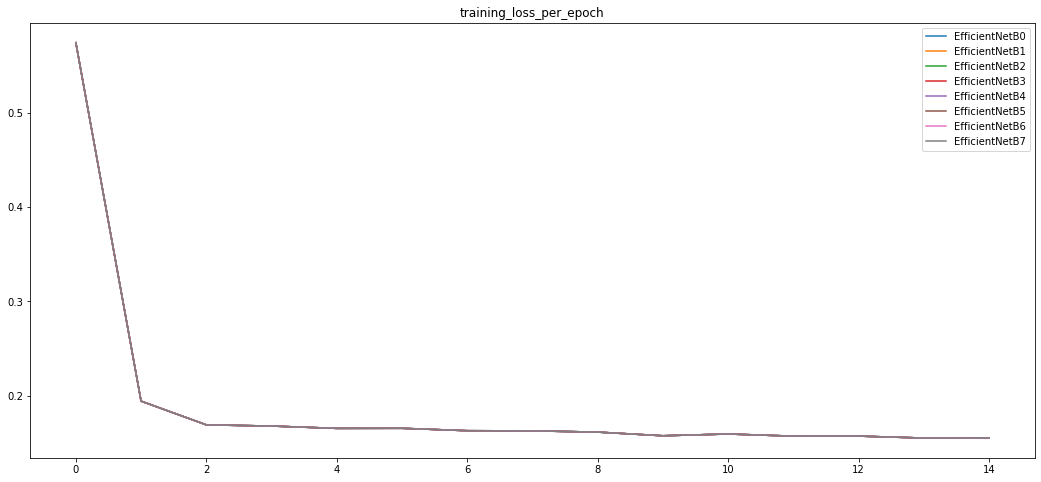

In [23]:
## loss graphing
train_loss = {}
i = 0
for arch in build_effnet_arch:
    eff_arch = str('EfficientNetB') + str(arch)
    train_loss[eff_arch] = select_EffNet_Family_history[i].history['loss']

train_loss_df = pd.DataFrame(train_loss)
## graphing...
train_loss_df.plot.line(title="training_loss_per_epoch", figsize=(18,8))


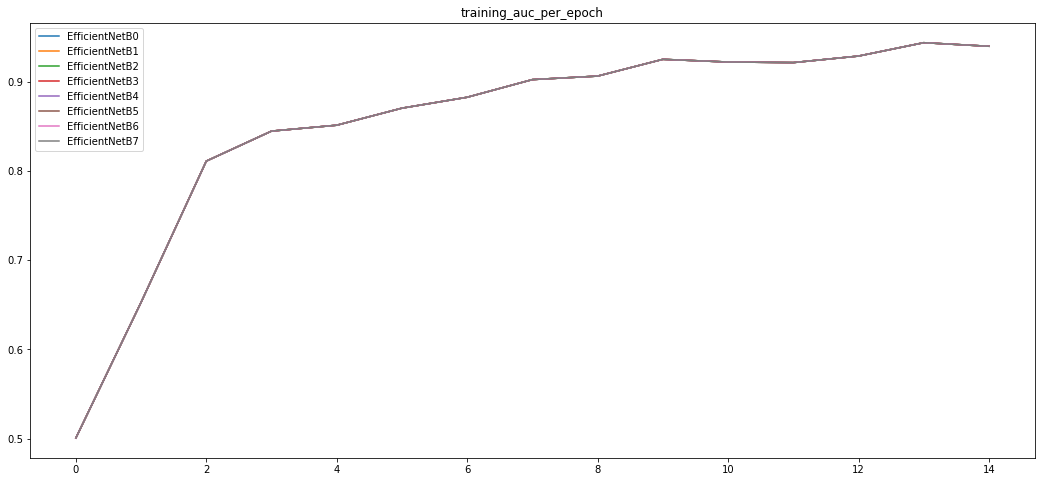

In [24]:
## loss graphing
train_auc = {}
i = 0
for arch in build_effnet_arch:
    eff_arch = str('EfficientNetB') + str(arch)
    train_auc[eff_arch] = select_EffNet_Family_history[i].history['auc']

train_auc_df = pd.DataFrame(train_auc)
## graphing...
train_auc_df.plot.line(title="training_auc_per_epoch", figsize=(18,8))


### Weighing EffNet Family for Prediction

- find weights using tree based classifier for weighing all the trained EffNets to get final prediction 
- strategy
    - find predictions of all effnets on train data
    - train a not-so-deep tree (grid seach depth?)
    - use tree on predictions of effnets on test set for final prediction

In [25]:
CFG['batch_size'] = 16
cnt_train   = count_data_items(files_train)
steps      = cnt_train / (CFG['batch_size'] * REPLICAS)
ds_trainAug = get_dataset(files_train, CFG, augment=False, repeat=False, 
                         labeled=True, return_image_names=True)

i = 0
## data dict of train predictions
train_preds = {}
for arch in build_effnet_arch:
    eff_arch = str('EfficientNetB') + str(arch)
    print('\nPredicting train samples using ',eff_arch)
    pred = select_EffNet_Family[i].predict(ds_trainAug, verbose=1, steps=steps)
    print('Test Predictions shape',pred.shape, end = '\n')
    pred = np.stack(pred)
    pred = pred[:,:cnt_train]
    pred = pred[:df_train.shape[0]]
    pred = pred.reshape(-1)
    train_preds[eff_arch] = pred
    i=i+1


Predicting train samples using  EfficientNetB0
256/255 [==============================] - 14s 53ms/step
Test Predictions shape (32692, 1)

Predicting train samples using  EfficientNetB1
256/255 [==============================] - 16s 63ms/step
Test Predictions shape (32692, 1)

Predicting train samples using  EfficientNetB2
256/255 [==============================] - 16s 63ms/step
Test Predictions shape (32692, 1)

Predicting train samples using  EfficientNetB3
256/255 [==============================] - 17s 68ms/step
Test Predictions shape (32692, 1)

Predicting train samples using  EfficientNetB4
256/255 [==============================] - 20s 79ms/step
Test Predictions shape (32692, 1)

Predicting train samples using  EfficientNetB5
256/255 [==============================] - 23s 91ms/step
Test Predictions shape (32692, 1)

Predicting train samples using  EfficientNetB6
256/255 [==============================] - 27s 107ms/step
Test Predictions shape (32692, 1)

Predicting train samples 

In [26]:
## getting labels
ds = get_dataset(files_train, CFG, augment=False, repeat=False, 
                 labeled=True, return_image_names=True)

image_labels = np.array([img_label
                        for img, img_label in iter(ds.unbatch())])

## add to the train_preds dict
train_preds['act_target'] = image_labels

## create a dataframe of train predictions from each model and target 
train_model_pred = pd.DataFrame(train_preds)
train_model_pred.head()

,EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5,EfficientNetB6,EfficientNetB7,act_target
0,0.028981,0.033412,0.034510,0.029994,0.031325,0.035527,0.027969,0.056277,0
1,0.024700,0.025826,0.028900,0.033372,0.027439,0.027398,0.025890,0.022316,0
2,0.020371,0.024608,0.022141,0.033146,0.027325,0.021328,0.019724,0.017261,0
3,0.020569,0.028371,0.026258,0.023657,0.038470,0.026567,0.030438,0.025069,0
4,0.020012,0.023472,0.033914,0.032524,0.025290,0.026700,0.026277,0.027456,0


In [27]:
## save
train_model_pred.to_csv(f'intermediate_results.csv', index=False)

In [28]:
## build the decision tree classifier on the ensembles predictions to get the final weighted target prediction
## KISS - small trees - play around for better perf
from sklearn import tree

ensemble_model = tree.DecisionTreeClassifier()
x_ls = [str('EfficientNetB') + str(arch) for arch in build_effnet_arch]
X_train = train_model_pred.loc[:,x_ls]
y_train = train_model_pred.loc[:,'act_target']
ensemble_model.fit(X_train, y_train)
y_predict = ensemble_model.predict(X_train)

## auc 
from sklearn import metrics
fpr, tpr, thresholds = metrics.roc_curve(y_train, y_predict)
print(metrics.auc(fpr, tpr))

1.0


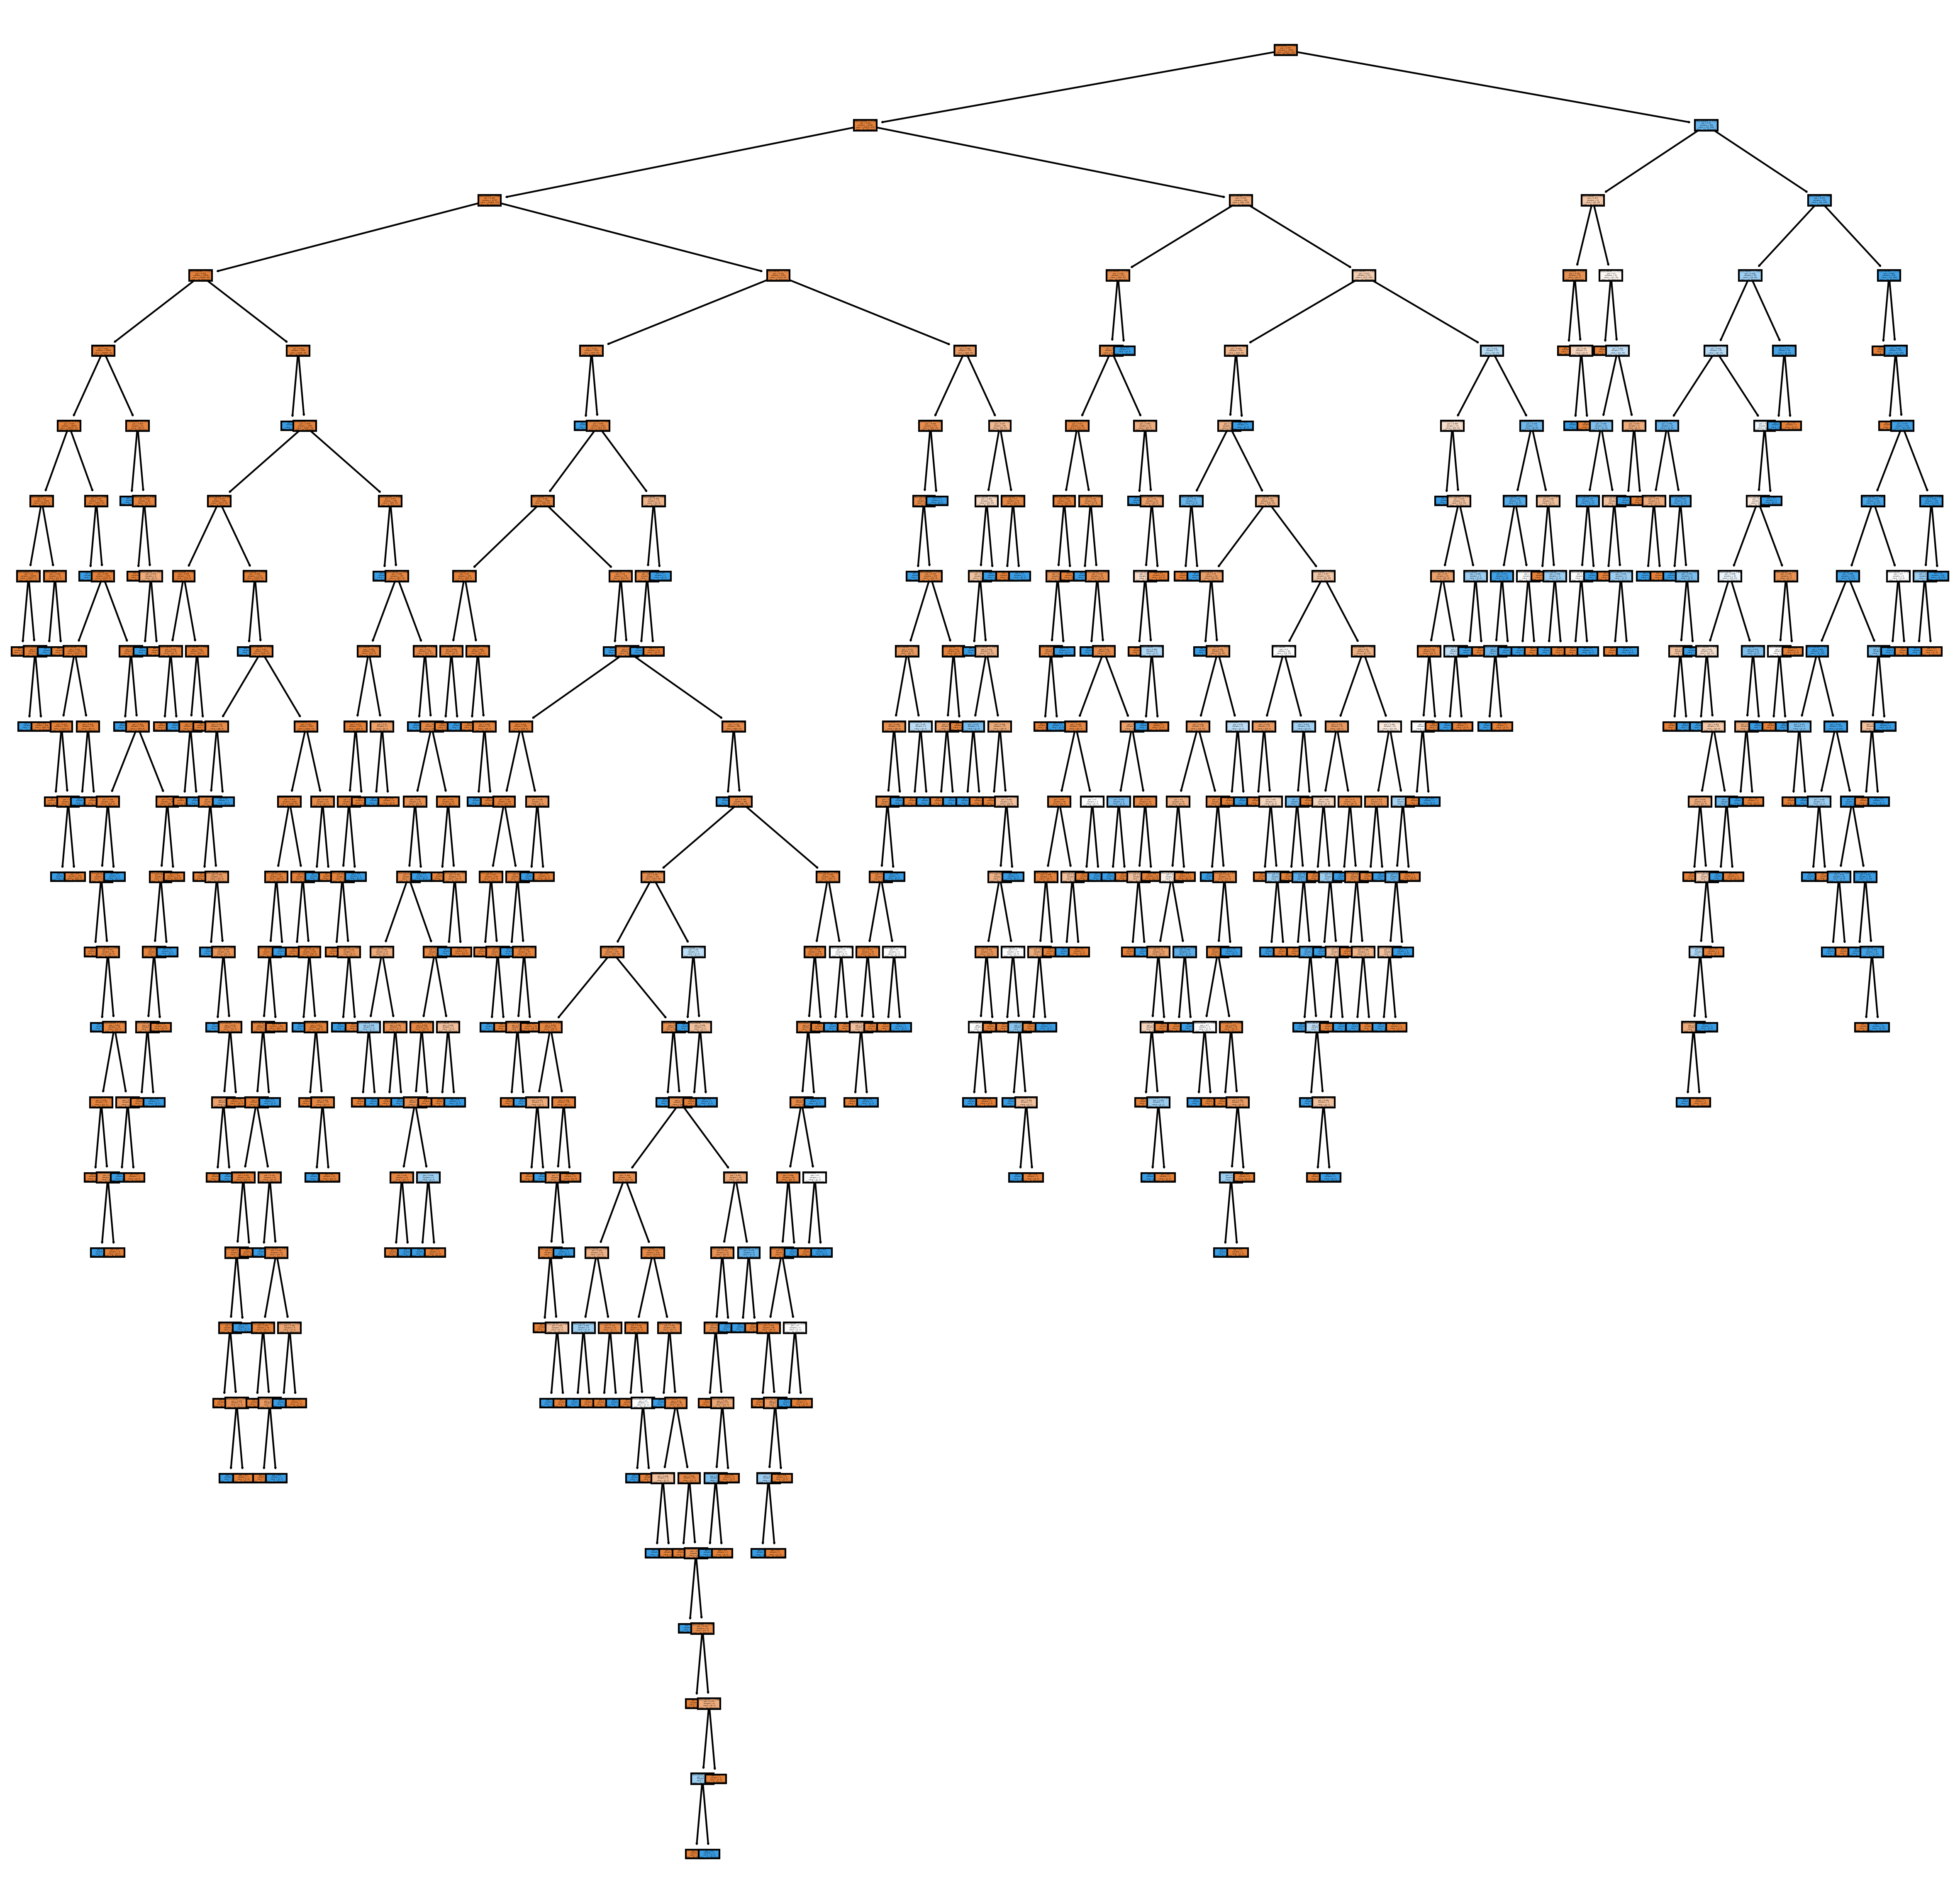

In [29]:
## vizuvalize the tree
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (20,20), dpi=300)

cn=['No_Melanoma', 'Yes_Melanoma']
tree.plot_tree(ensemble_model
               , feature_names = x_ls
               , class_names=cn
               , filled = True)

fig.show()

## TestSet Prediction

- use the tree classifier above to combine predictions from individual EffNet model
- Straight average the predictions from all the models 

In [30]:
CFG['batch_size'] = 256

cnt_test   = count_data_items(files_test)
steps      = cnt_test / (CFG['batch_size'] * REPLICAS) * CFG['tta_steps']
ds_testAug = get_dataset(files_test, CFG, augment=True, repeat=True, 
                         labeled=False, return_image_names=False)


i = 0
test_preds = {}
for arch in build_effnet_arch:
    eff_arch = str('EfficientNetB') + str(arch)
    print('\nPredicting test samples using ',eff_arch)
    pred = select_EffNet_Family[i].predict(ds_testAug, verbose=1, steps=steps)
    print('Test Predictions (tta) shape',pred.shape)
    pred = np.stack(pred)
    pred = pred[:,:cnt_test* CFG['tta_steps']]
    pred = pred[:df_test.shape[0]*CFG['tta_steps']]
    pred = np.stack(np.split(pred, CFG['tta_steps']),axis=1)
    pred = np.mean(pred, axis=1)
    pred = pred.reshape(-1)
    test_preds[eff_arch] = pred
    i=i+1

test_ensemble_pred = pd.DataFrame(test_preds)


Predicting test samples using  EfficientNetB0
135/134 [==============================] - 75s 559ms/step
Test Predictions (tta) shape (276480, 1)

Predicting test samples using  EfficientNetB1
135/134 [==============================] - 75s 558ms/step
Test Predictions (tta) shape (276480, 1)

Predicting test samples using  EfficientNetB2
135/134 [==============================] - 76s 562ms/step
Test Predictions (tta) shape (276480, 1)

Predicting test samples using  EfficientNetB3
135/134 [==============================] - 76s 565ms/step
Test Predictions (tta) shape (276480, 1)

Predicting test samples using  EfficientNetB4
135/134 [==============================] - 77s 567ms/step
Test Predictions (tta) shape (276480, 1)

Predicting test samples using  EfficientNetB5
135/134 [==============================] - 77s 568ms/step
Test Predictions (tta) shape (276480, 1)

Predicting test samples using  EfficientNetB6
135/134 [==============================] - 76s 566ms/step
Test Predictions (t

In [31]:
## save intermediate
test_ensemble_pred.to_csv(f'intermediate_test_results.csv', index=False)

In [32]:
## use tree classifier from above to combine test predictions
tree_predict = ensemble_model.predict_proba(test_ensemble_pred)[:,1]
print(tree_predict.shape)

## straight average test predictions
preds = test_ensemble_pred.sum(axis=1)/test_ensemble_pred.shape[1]
print(preds.shape)

(10982,)
(10982,)


### **Submission**

In [33]:
## create the image names
ds = get_dataset(files_test, CFG, augment=False, repeat=False, 
                 labeled=False, return_image_names=True)

image_names = np.array([img_name.numpy().decode("utf-8") 
                        for img, img_name in iter(ds.unbatch())])

In [34]:
## preds for decision tree

submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = tree_predict))

submission = submission.sort_values('image_name') 
submission.to_csv(f'submission_1.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.0
1443,ISIC_0052349,0.0
3120,ISIC_0058510,0.0
4870,ISIC_0073313,0.0
5494,ISIC_0073502,0.0


In [35]:
## preds for straight averaging

submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = preds))

submission = submission.sort_values('image_name') 
submission.to_csv(f'submission_2.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.035510
1443,ISIC_0052349,0.023760
3120,ISIC_0058510,0.025473
4870,ISIC_0073313,0.024796
5494,ISIC_0073502,0.031480


In [36]:
test_ensemble_pred.head()

,EfficientNetB0,EfficientNetB1,EfficientNetB2,EfficientNetB3,EfficientNetB4,EfficientNetB5,EfficientNetB6,EfficientNetB7
0,0.031689,0.021242,0.026098,0.029624,0.028933,0.026340,0.027675,0.026686
1,0.027115,0.026060,0.029567,0.030635,0.027954,0.027164,0.030228,0.032277
2,0.026896,0.022916,0.026069,0.023101,0.022536,0.026391,0.025408,0.026878
3,0.018482,0.033045,0.021323,0.029391,0.031935,0.028121,0.022044,0.031089
4,0.023792,0.023152,0.024387,0.028704,0.029045,0.027746,0.026082,0.021934


In [43]:
## just use B7 predictions - all nets were tracking eachothers performance on test from the graphs above 
submission = pd.DataFrame(dict(
    image_name = image_names,
    target     = test_ensemble_pred['EfficientNetB0']))

submission = submission.sort_values('image_name') 
submission.to_csv(f'submission_10.csv', index=False)
submission.head()

,image_name,target
9905,ISIC_0052060,0.039280
1443,ISIC_0052349,0.022459
3120,ISIC_0058510,0.024196
4870,ISIC_0073313,0.025875
5494,ISIC_0073502,0.025546


## Sources/Acknowlegements:

- AgentAuers's notebook : https://www.kaggle.com/agentauers/incredible-tpus-finetune-effnetb0-b6-at-once
- Kaggle Documentation 
- EffNets google blog

## Next Steps:
- Add past years data 
- Add eval mode - validation set 
- loss function - penalize false negetives more?